# Introduction - Advanced session

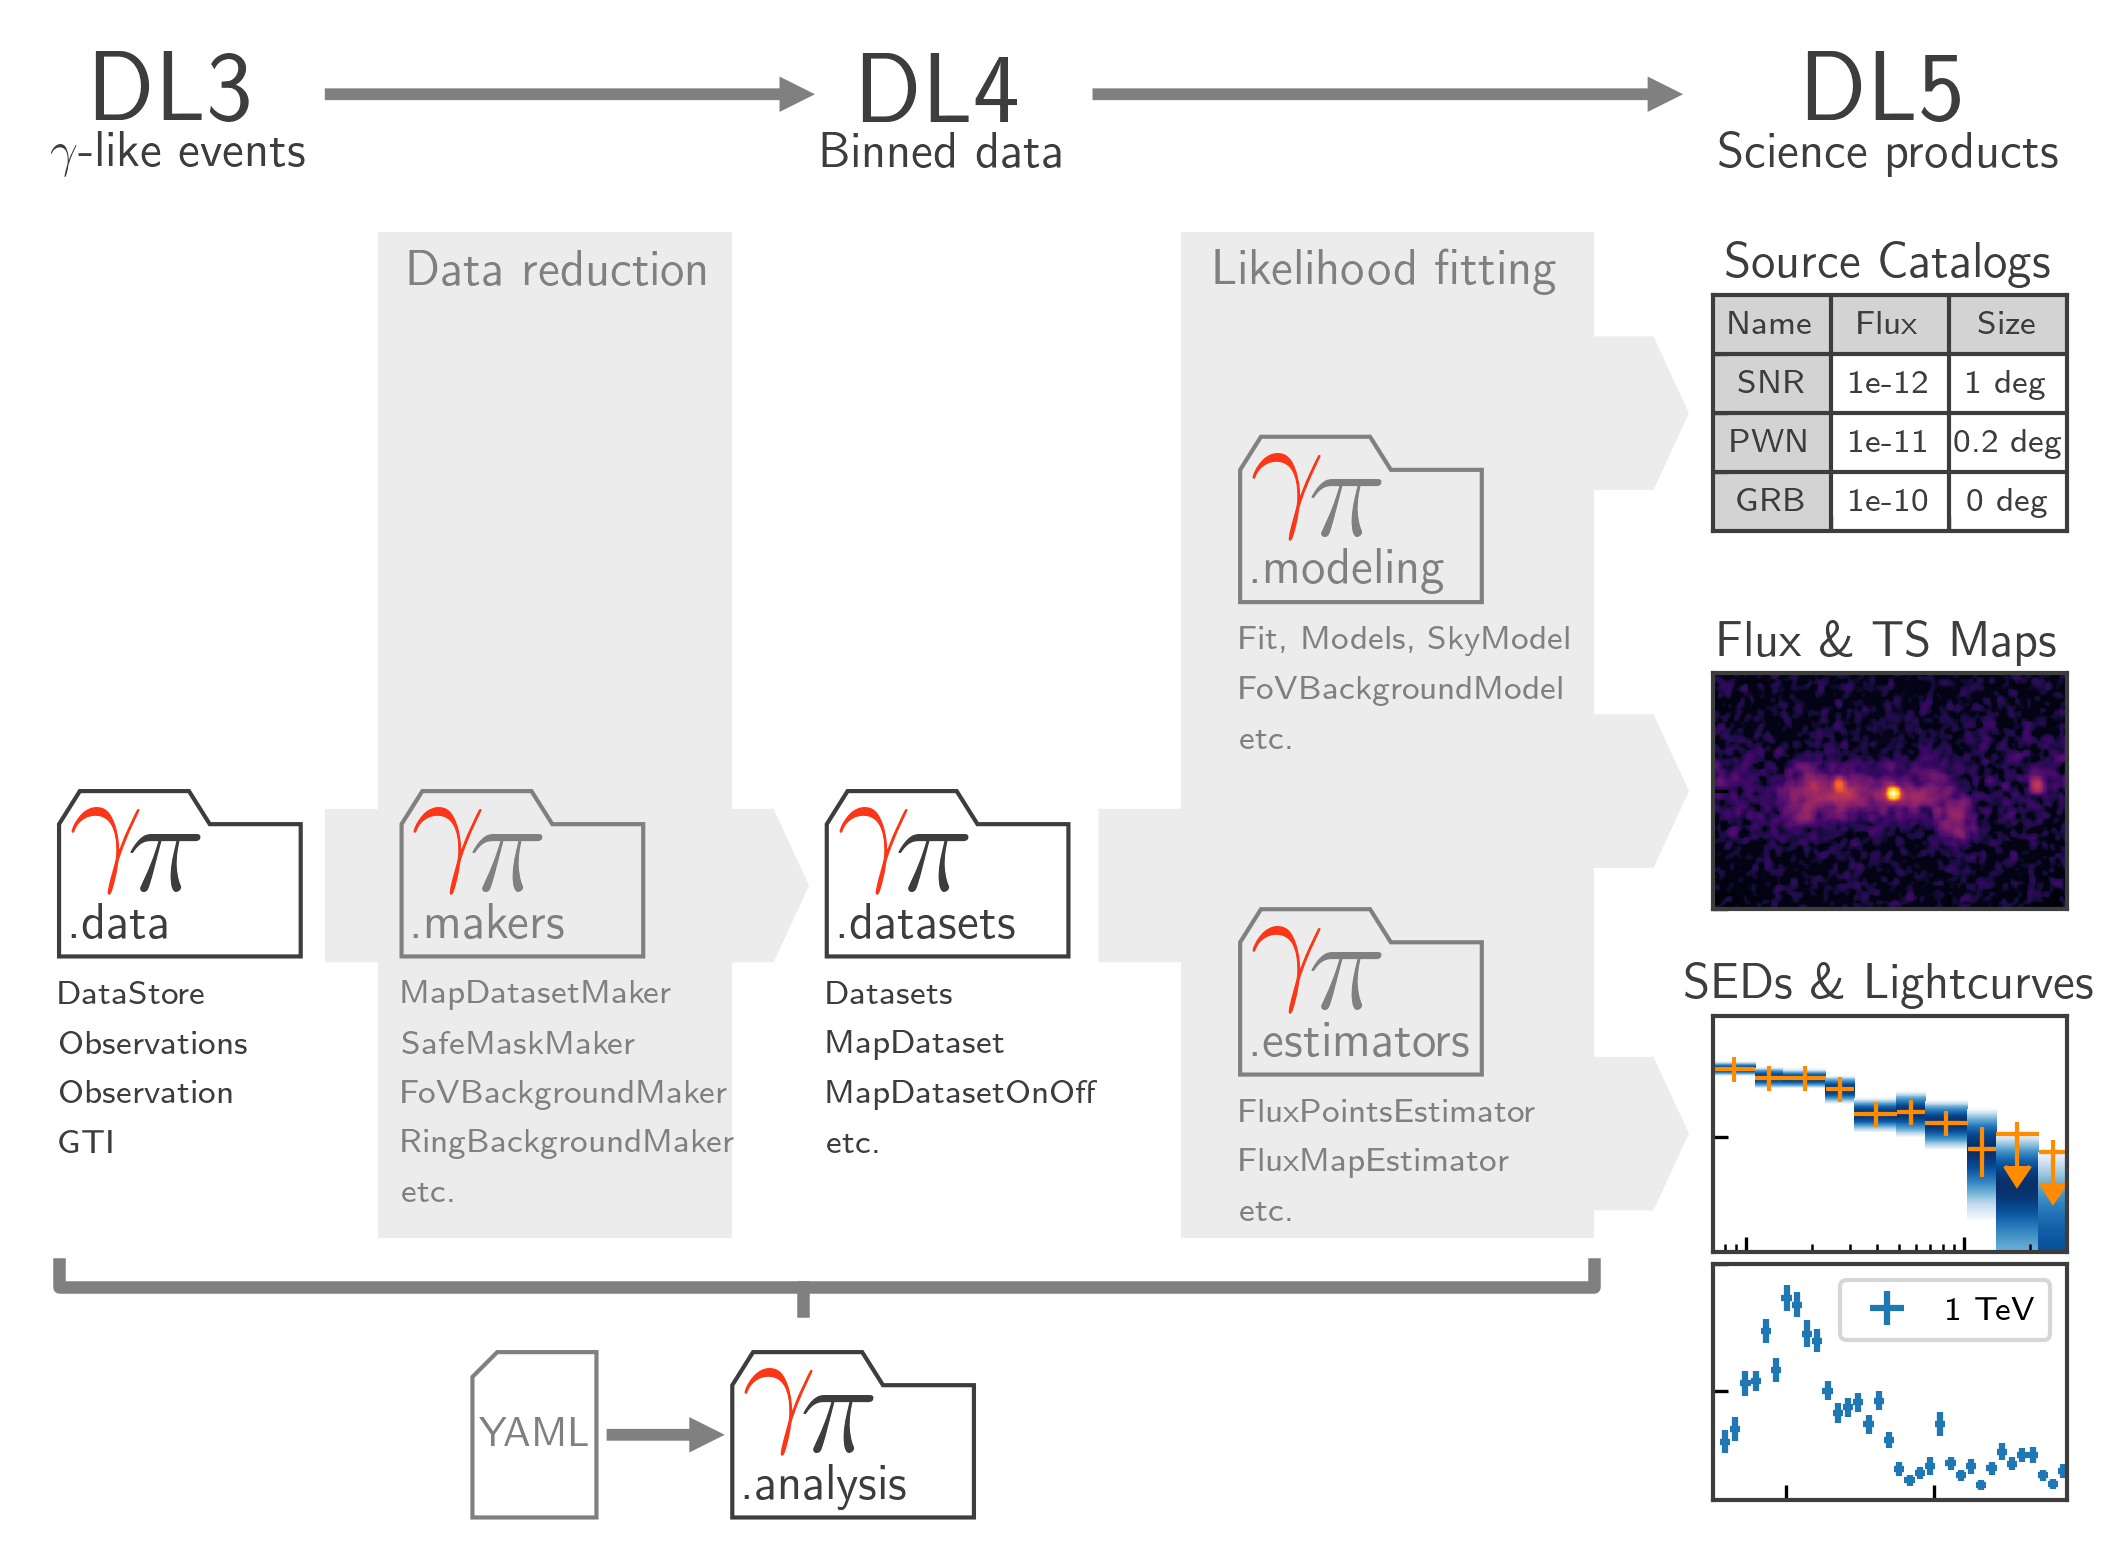

## 1. The DL3 data model

- Event lists and Instrument Response Functions
- Data and IRF model from the GADF: https://gamma-astro-data-formats.readthedocs.io/en/v0.3/
- For IACT, every run is stored with an unique `obs_id`. The `hdu_index_table` links the event list with its associated IRF. The `obs_index_table` gives quick info on stored runs. Each each run has only one associated event list and IRF

- `point-like` and `full-enclosure` IRFs

In [2]:
from gammapy.data import EventList, GTI, Observations, DataStore
from gammapy.irf import *

### Full enclosure irf

In [3]:
data_store_hess = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
data_store_hess.info()

Data store:
HDU index table:
BASE_DIR: /home/atreyeesinha/Work/gammapy-datasets/1.2/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [4]:
obs_hess = data_store_hess.obs(23559)

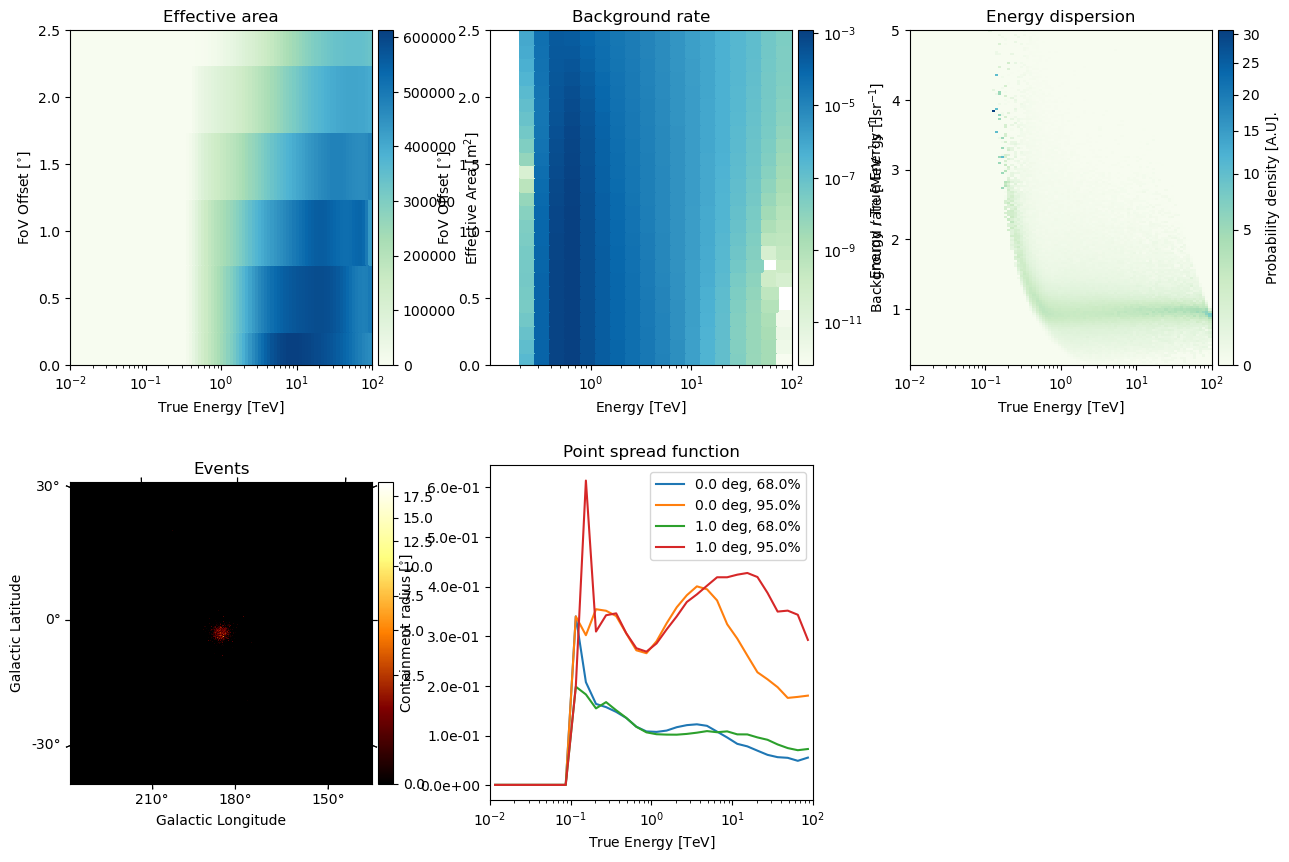

In [5]:
obs_hess.peek()

In [6]:
aeff = obs_hess.aeff

In [7]:
aeff

In [8]:
aeff.meta

OrderedDict([('EXTNAME', 'AEFF'),
             ('CREF5', '(ENERG_LO:ENERG_HI,THETA_LO:THETA_HI)'),
             ('HDUCLASS', 'GADF'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('ORIGIN', 'H.E.S.S. Collaboration'),
             ('INSTRUME', 'H.E.S.S. Phase I'),
             ('TELESCOP', 'HESS'),
             ('EV_CLASS', 'std'),
             ('HDUCLAS1', 'RESPONSE'),
             ('HDUCLAS2', 'EFF_AREA'),
             ('HDUCLAS3', 'FULL-ENCLOSURE'),
             ('HDUCLAS4', 'AEFF_2D'),
             ('OBS_ID', 23559),
             ('TELPAT', 30),
             ('CONFIG', 'std_fullEnclosure_fits_release'),
             ('AZIMUTH', 2.25357982930731),
             ('ZENITH', 45.3681758903868),
             ('LO_THRES', 0.660693448007596),
             ('HI_THRES', 100.0),
             ('comments',
              ['This file is part of the first H.E.S.S. FITS test data release from 2

/home/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


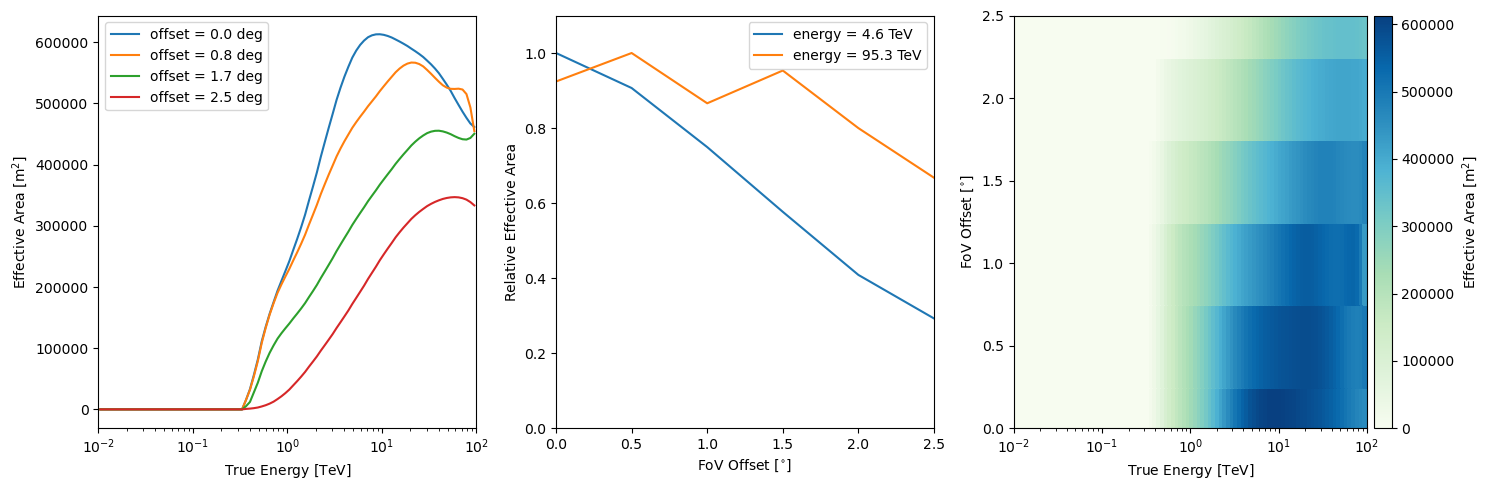

In [9]:
aeff.peek()

### point-like IRF

In [10]:
data_store_magic = DataStore.from_dir("$GAMMAPY_DATA/magic/rad_max/data")

In [11]:
observations = data_store_magic.get_observations()
print(observations)

Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 5029747
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 5029748


Observations
Number of observations: 0



In [12]:
observations = data_store_magic.get_observations(required_irf="point-like")

In [13]:
obs_magic = observations[0]

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


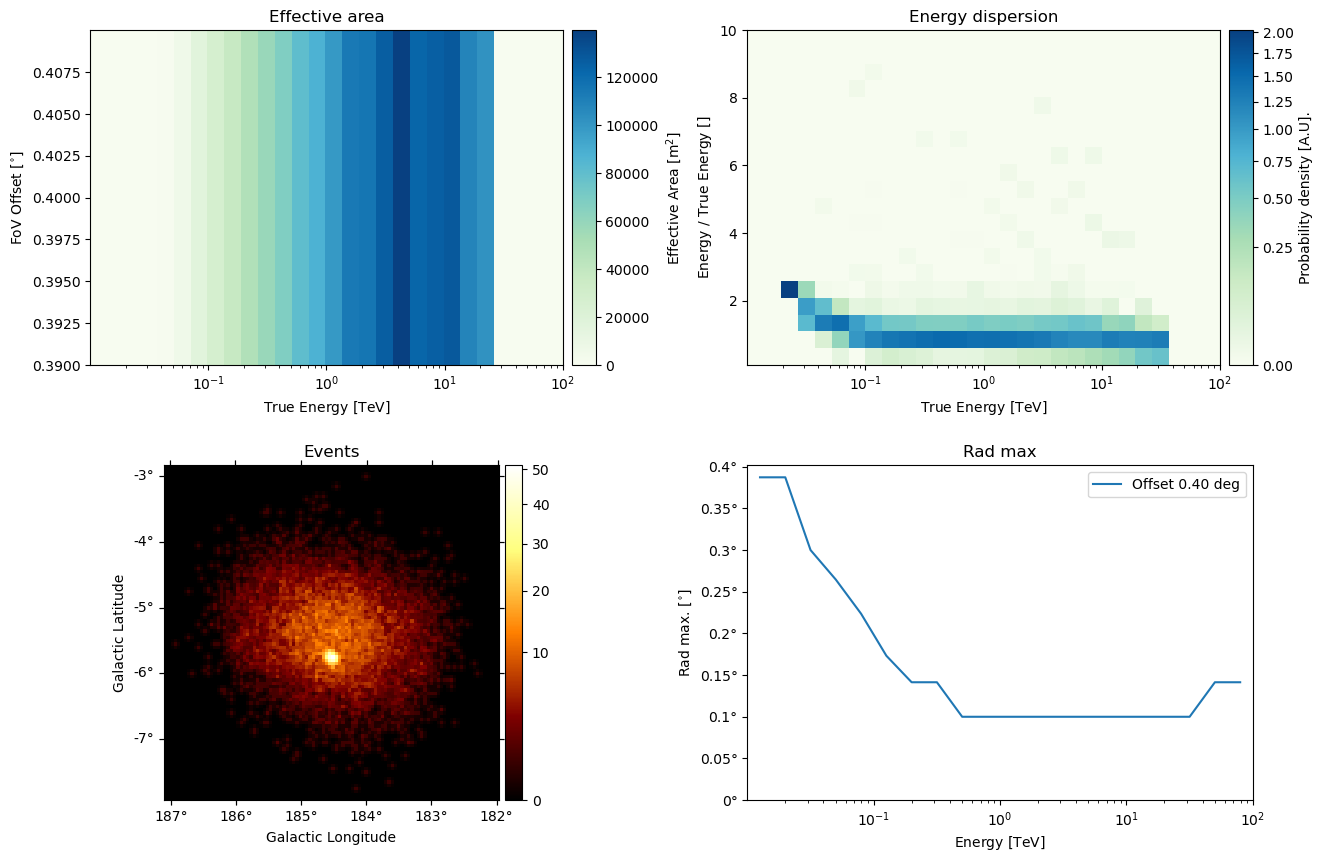

In [14]:
obs_magic.peek()

In [15]:
obs_magic.aeff

'THETA' axis is stored as a scalar -- converting to 1D array.


In [16]:
obs_magic.aeff.meta

'THETA' axis is stored as a scalar -- converting to 1D array.


OrderedDict([('EXTNAME', 'EFFECTIVE AREA'),
             ('HDUCLASS', 'GADF'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('HDUCLAS1', 'RESPONSE'),
             ('HDUCLAS2', 'EFF_AREA'),
             ('HDUCLAS3', 'POINT-LIKE'),
             ('HDUCLAS4', 'AEFF_2D'),
             ('CREF5', '(ENERG_LO:ENERG_HI,THETA_LO:THETA_HI)'),
             ('OBS_ID', 5029747),
             ('LO_THRES', 0.08576008)])

Possible to have 3D IRFs: https://docs.gammapy.org/dev/tutorials/api/irfs.html#support-for-asymmetric-irfs

## Data reduction - DL3 to DL4

1. `point-like` irf :
 - only spectral (1D) analysis
 - region size fixed: use a `PointSkyRegion`, correction to be applied automatically from the `RadMax` values
 - usually no background model - background to be estimated using `WobbleRegionsFinder`
 - ON-OFF analysis - `wstat`
    
2. `full-enclosure` irf:

   - *spectral* (1D), `morphological` (2D) and 3D analysis possible
   - A `3D` analysis:
   - - `MapDataset` : Background estimated from a model
     - `MapDatasetOnOff`: Background estimated 
   - For a `1D` analysis:
   - -`SpectrumDatasetOnOff`: Background extracted from real 

### Creating a MapDataset

- We choose one run of MSH 1552 from the H.E.S.S. public data release.
- In practice, will have more than one run and can either create multiple datasets and fit them together (joint analysis) or one averaged dataset (stacked analysis).

In [96]:
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from astropy.coordinates import SkyCoord
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.maps import *
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator

import astropy.units as u

In [45]:
obs = data_store_hess.obs(20136)

source_pos = SkyCoord(228.32, -59.08, unit="deg")
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 5, unit="TeV", per_decade=True)

geom = WcsGeom.create(
    skydir=source_pos,
    binsz=0.02,
    width=3.0,
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 10, unit="TeV", name="energy_true", per_decade=True
)

stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="stacked"
)

In [74]:
offset_max = 2.5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=offset_max
)

In [204]:
# First a cutout of the target map is produced
cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
# A MapDataset is filled in this cutout geometry
dataset = maker.run(cutout, obs)
# The data quality cut is applied
dataset = maker_safe_mask.run(dataset, obs)
# The resulting dataset cutout is stacked onto the final one
stacked.stack(dataset)

In [205]:
print(stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 11747 
  Total background counts         : 9460.89
  Total excess counts             : 2286.11

  Predicted counts                : 9460.89
  Predicted background counts     : 9460.89
  Predicted excess counts         : nan

  Exposure min                    : 1.03e-02 m2 s
  Exposure max                    : 2.22e+09 m2 s

  Number of total bins            : 180000 
  Number of fit bins              : 180000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### FoV modelling - does the background match in the source free region?

In [206]:
from regions import CircleSkyRegion
reg1 = CircleSkyRegion(center=SkyCoord(229.62, -60.01, unit="deg"), radius=0.5*u.deg)

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

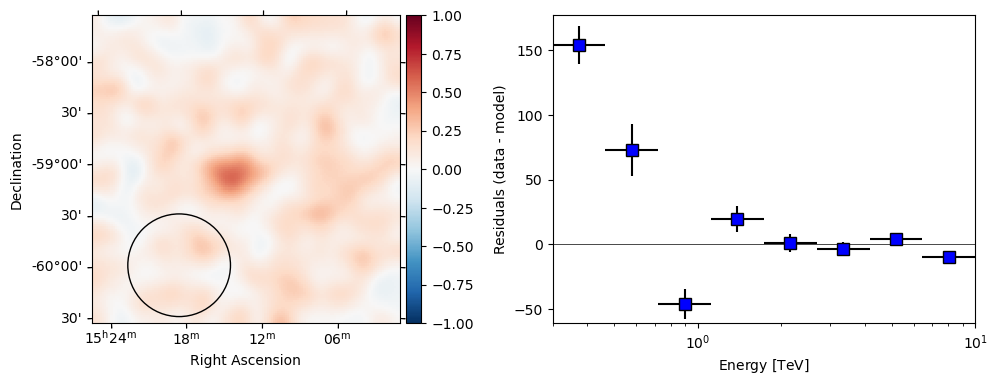

In [207]:
kwargs_spatial = {"cmap": "RdBu_r", "vmin":-1, "vmax":1, "add_cbar": True}
kwargs_spectral = {"region":reg1, "markerfacecolor": "blue", "markersize": 8, "marker": "s"}
stacked.plot_residuals(kwargs_spectral=kwargs_spectral, kwargs_spatial=kwargs_spatial)

Fit the observed counts in the source free region to the expection from the background template.
You can use different spectral/spatial corrections

In [208]:
from gammapy.modeling.models import *

In [209]:
s1 = PowerLawNormSpectralModel()
s1.tilt.frozen = False

<WCSAxes: >

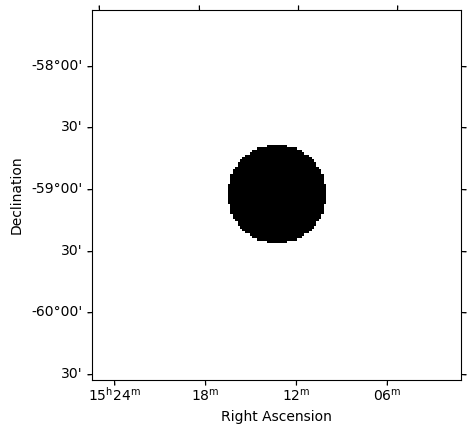

In [264]:
src_reg = CircleSkyRegion(center=source_pos, radius=0.4*u.deg)
exclusion_mask = geom.region_mask([src_reg], inside=False)
exclusion_mask.sum_over_axes().plot()

In [265]:
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask, spectral_model=s1)

In [266]:
dataset1 = maker_fov.run(dataset.copy())

In [267]:
dataset1.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str3,float64,float64,float64,bool,bool,str1,str1
,norm,1.0178e+00,,1.960e-02,nan,nan,False,True,,
,tilt,3.6741e-02,,3.031e-02,nan,nan,False,False,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,


In [268]:
dataset1.npred_background().data.sum(), dataset1.background.data.sum()

(3810.2815636919127, 3706.003998799473)

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

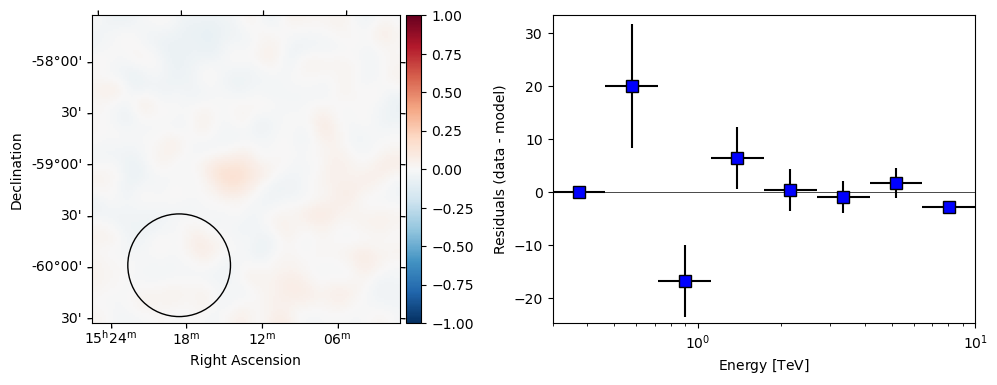

In [269]:
kwargs_spatial = {"cmap": "RdBu_r", "vmin":-1, "vmax":1, "add_cbar": True}
kwargs_spectral = {"region":reg1, "markerfacecolor": "blue", "markersize": 8, "marker": "s"}
dataset1.plot_residuals(kwargs_spectral=kwargs_spectral, kwargs_spatial=kwargs_spatial)

Choose a different background model

In [270]:
s2 = PiecewiseNormSpectralModel(energy=energy_axis.downsample(2).center)

In [271]:
maker_fov2 = FoVBackgroundMaker(spectral_model=s2, exclusion_mask=exclusion_mask, method="fit")


In [272]:
dataset.models = None

In [273]:
dataset2 = maker_fov2.run(dataset.copy())

In [274]:
dataset2.models

Set a prior on the normalisations

Using priors: https://docs.gammapy.org/dev/tutorials/api/priors.html

**Essential to have some good knowledge of the prior**

In [275]:
s3 = PiecewiseNormSpectralModel(energy=energy_axis.downsample(2).center)

In [276]:
from gammapy.modeling.models import GaussianPrior

In [277]:
# We "know" that H.E.S.S. systematics is around 10%
for p in s3.parameters:
    p.prior = GaussianPrior(mu=1, sigma=0.1)

In [278]:
maker_fov3 = FoVBackgroundMaker(spectral_model=s3, exclusion_mask=exclusion_mask, method="fit")
dataset3 = maker_fov3.run(dataset.copy())
dataset3.models

Q: What is a good model to use? 

A: You want to have a flat significance distribution outside the exclusion mask in different energy bands
- From Wilks' theorem, a Gaussian with mu=0, std=1

In [279]:
est = ExcessMapEstimator(energy_edges=[0.3, 1, 10]*u.TeV)
dataset2.mask_fit = exclusion_mask
exc = est.run(dataset2)

In [280]:
from scipy import stats

<WCSAxes: >

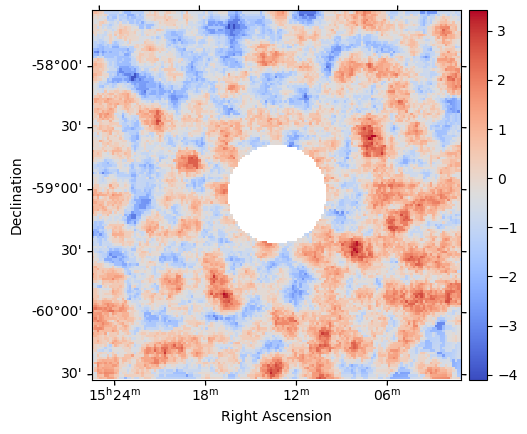

In [281]:
exc.sqrt_ts.get_image_by_idx([0]).plot(add_cbar=True, cmap="coolwarm")


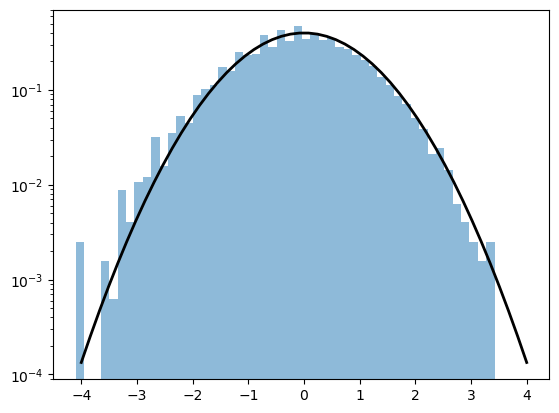

In [282]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(exc.sqrt_ts.get_image_by_idx([0]).data.ravel(), bins=50, alpha=0.5, density=True);
x = np.linspace(-4, 4, 50)
p = stats.norm.pdf(x, 0, 1)
plt.plot(x, p, lw=2, color="black")
plt.yscale("log")

What is a good mask to choose?

- The PSF radius for point sources
- psf + source size for extended sources

- Lets choose a "bad" mask to see what happens

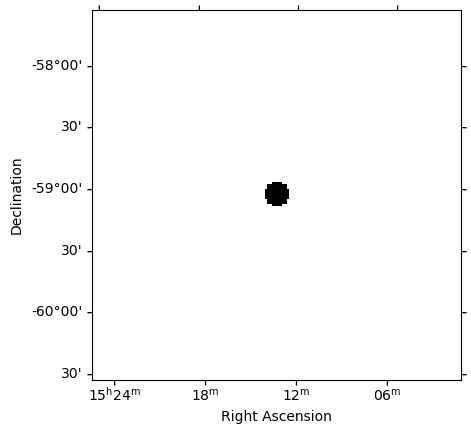

In [283]:
src_reg_bad = CircleSkyRegion(center=source_pos, radius=0.1*u.deg)
exclusion_mask_bad = geom.region_mask([src_reg_bad], inside=False)
exclusion_mask_bad.sum_over_axes().plot()
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask_bad, spectral_model=s1)

<WCSAxes: >

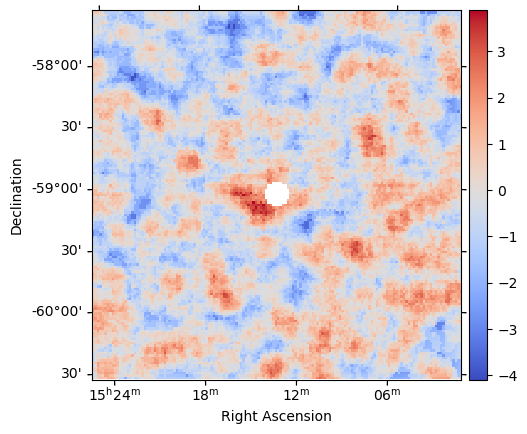

In [284]:
dataset4 = maker_fov.run(dataset.copy())
dataset4.mask_fit = exclusion_mask_bad
exc2=est.run(dataset4)
exc2.sqrt_ts.get_image_by_idx([0]).plot(add_cbar=True, cmap="coolwarm")


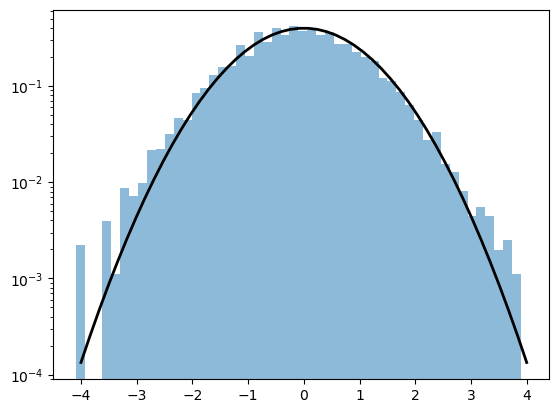

In [285]:
plt.hist(exc2.sqrt_ts.get_image_by_idx([0]).data.ravel(), bins=50, alpha=0.5, density=True);
x = np.linspace(-4, 4, 50)
p = stats.norm.pdf(x, 0, 1)
plt.plot(x, p, lw=2, color="black")
plt.yscale("log")

- Here, we are checking for just one run. The significamnce maps should be combined over all runs
- Look at the distribution of the fitted parameters over all runs. Investigate the outliers
- If the significance distribution is not good, modify the exclusion mask.
  - Increase the size of the source region
  - Choose masks from previous knowlegde (eg: known sources, mask the galactic plane, etc..)
  - Use an iterative masking process

## Modeling and extraction of Flux points

1. Perform a `Fit`
   - Model the source
   - If there are additional sources in the FoV, you can either model all sources simultaneously, or mask some of them
3. Use `Estimator` to obtain flux maps

<WCSAxes: >

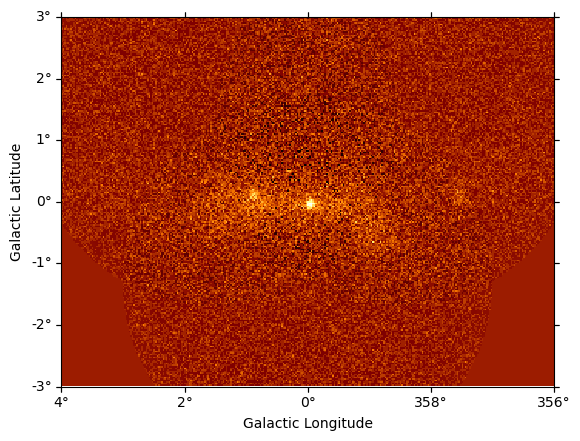

In [291]:
cta_dataset = MapDataset.read(
    "$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="cta_dataset"
)
cta_dataset.excess.sum_over_axes().plot(stretch="sqrt")

In [292]:
model1 = ..
model2 = ..
bkg_model = ...
cta_dataset.models = Models([model1, model2, bkg_model...])

SyntaxError: invalid syntax (3936219550.py, line 1)

<WCSAxes: >

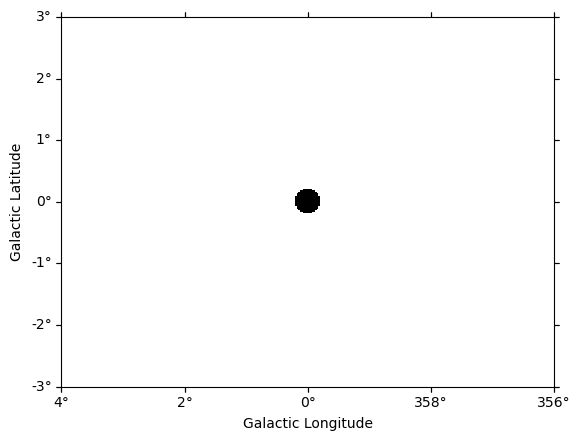

In [299]:
mask = cta_dataset.geoms["geom"].region_mask(CircleSkyRegion(center=SkyCoord(0, 0, frame="galactic", unit="deg"), radius=0.2*u.deg), 
                                             inside=False)
mask.sum_over_axes().plot()

In [ ]:
cta_dataset.mask_fit = mask
cta_dataset.models = Models([model2, bkg_model])

- If you have nearby sources, they should be modelled together to account correctly for the overlapping contributions
- Modelling many sources simultaneously is complex! And time intensive

### Eg 1: Book keeping of multiple models and datasets

Lets say we have two datasets and many sources in the field.
Some sources are common between the two datasets, and some are present only one one.

In [301]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt

# %matplotlib inline
from IPython.display import display
from gammapy.catalog import SourceCatalog3FHL
from gammapy.datasets import Datasets, MapDataset
from gammapy.maps import Map
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
    PowerLawNormSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    create_fermi_isotropic_diffuse_model,
)

In [303]:
fermi_dataset = MapDataset.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc.fits.gz", name="fermi_dataset"
)
cta_dataset = MapDataset.read(
    "$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="cta_dataset"
)
datasets = Datasets([fermi_dataset, cta_dataset])
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : 




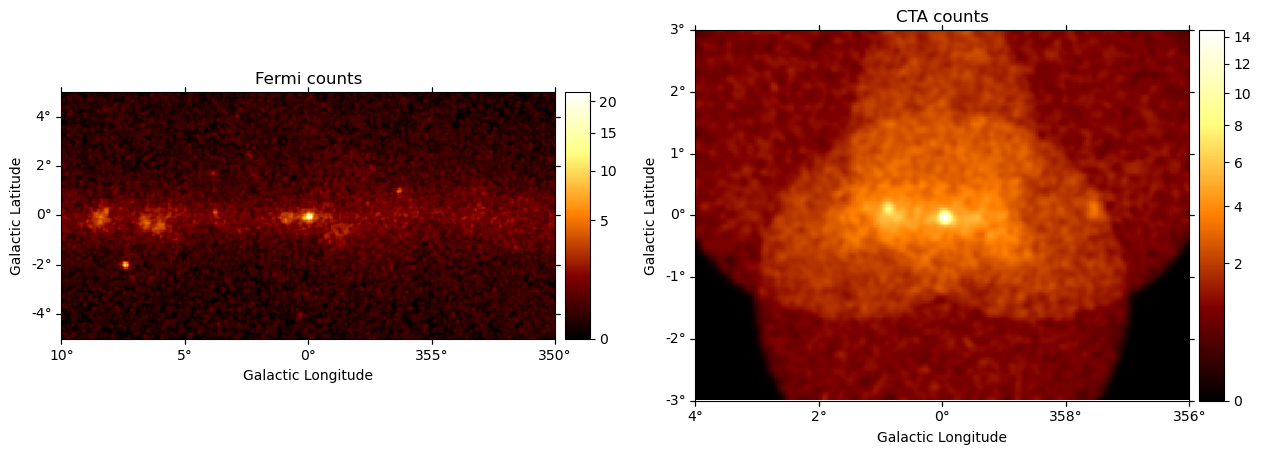

In [304]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=fermi_dataset.counts.geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset.counts.geom.wcs)


datasets[0].counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    ax=ax1, stretch="sqrt", add_cbar=True
)
datasets[1].counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    ax=ax2, stretch="sqrt", add_cbar=True
)
ax1.set_title("Fermi counts")
ax2.set_title("CTA counts")
plt.show()

In [380]:
# Assign each model to the datasets it belongs to


# Create the FoV background model for CTA data

bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)

# Read the fermi isotropic diffuse background model

diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename="$GAMMAPY_DATA/fermi_3fhl/iso_P8R2_SOURCE_V6_v06.txt",
)
diffuse_iso.datasets_names = fermi_dataset.name  # specifying the dataset name
diffuse_iso.spectral_model.parameters["norm"].prior = GaussianPrior(mu=1, sigma=0.1)


# Create the diffuse model
diffuse_galactic_fermi = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz")

template_diffuse = TemplateSpatialModel(
    diffuse_galactic_fermi, normalize=False
)  # the template model in this case is already a full 3D model, it should not be normalised

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
    datasets_names=[
        cta_dataset.name,
        fermi_dataset.name,
    ],  # specifying list of dataset names
)  # A power law spectral correction is applied in this case

models = Models([bkg_model, diffuse_iso, diffuse_iem]) # global models object


# add it to the datasets, and inspect
datasets.models = models


print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg', 'diffuse-iem']




In [318]:
from gammapy.modeling import Fit

In [319]:
fit2 = Fit()
result2=fit2.run(datasets)

In [323]:
result2.success

True

In [320]:
result2.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str17,str1,str9,float64,str4,float64,float64,float64,bool,bool,str1,str13
fermi-diffuse-iso,,norm,6.4315e-01,,9.267e-02,nan,nan,False,True,,GaussianPrior
fermi-diffuse-iso,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,
fermi-diffuse-iso,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
fermi-diffuse-iso,,value,1.0000e+00,sr-1,0.000e+00,nan,nan,True,False,,
diffuse-iem,,norm,2.0112e-01,,7.991e-03,nan,nan,False,True,,
diffuse-iem,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,
diffuse-iem,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
diffuse-iem,,lon_0,0.0000e+00,deg,0.000e+00,nan,nan,True,False,,
diffuse-iem,,lat_0,-6.2500e-02,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,,


In [324]:
result2.total_stat

595946.6271875538

Similarly, you can keep adding more sources to model...

Lets model the source at the Galactic center

In [385]:
model_GC_spatial = GaussianSpatialModel(frame="galactic")
model_GC_spatial.lon_0.value = 0.4
model_GC_spatial.sigma.value

model_GC_spectral = PowerLawSpectralModel()
model_GC.spectral_model.amplitude.value = 3e-11
model_GC.spectral_model.index.value = 1.0

model_GC = SkyModel(spatial_model=model_GC_spatial, spectral_model=model_GC_spectral, name="GC")


In [ ]:
models.append(model_GC)
datasets.models = models

In [386]:
result3=fit2.run(datasets)

/home/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages

In [387]:
result3

In [388]:
result3.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str13
,norm,8.3732e-01,,9.279e-02,nan,nan,False,True,,GaussianPrior
,norm,1.3298e-01,,8.151e-03,nan,nan,False,True,,
,index,2.1322e+00,,1.378e-02,nan,nan,False,False,,
,amplitude,1.5787e-11,TeV-1 s-1 cm-2,5.235e-13,nan,nan,False,True,,
,lon_0,1.2191e-01,deg,1.671e-02,nan,nan,False,False,,
,lat_0,-6.5918e-02,deg,1.041e-02,-9.000e+01,9.000e+01,False,False,,
,sigma,3.9777e-01,deg,9.741e-03,0.000e+00,nan,False,False,,
,norm,1.0879e+00,,3.649e-03,nan,nan,False,True,,


### Eg: What to do when a fit fails

1. Add parameters min and max values
2. Set resonable starting points
3. Add a `mask_fit` to mask unwanted pixels
4. Choose a different minimizer
5. Move to other techniques! MCMC etc...

In [389]:
model_GC_spectral.amplitude.value = 2e-12
model_GC_spatial.lat_0.min = -0.3
model_GC_spatial.lat_0.max = 0.3
model_GC_spatial.lon_0.min = -0.3
model_GC_spatial.lon_0.max = 0.3
model_GC_spatial.sigma.value = 0.1
model_GC.spatial_model.sigma.max = 0.2

In [401]:
result3=fit2.run(datasets)

In [402]:
result3

In [403]:
result3.models.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str13
,norm,8.3736e-01,,9.279e-02,nan,nan,False,True,,GaussianPrior
,norm,1.3298e-01,,8.151e-03,nan,nan,False,True,,
,index,2.1322e+00,,1.379e-02,nan,nan,False,False,,
,amplitude,1.5787e-11,TeV-1 s-1 cm-2,5.231e-13,nan,nan,False,True,,
,lon_0,1.2190e-01,deg,1.670e-02,nan,nan,False,False,,
,lat_0,-6.5922e-02,deg,1.041e-02,-9.000e+01,9.000e+01,False,False,,
,sigma,3.9778e-01,deg,9.731e-03,0.000e+00,nan,False,False,,
,norm,1.0879e+00,,3.649e-03,nan,nan,False,True,,


Or, change the minimiser:

In [393]:
scipy_opts = {
    "method": "L-BFGS-B",
    "options": {"ftol": 1e-4, "gtol": 1e-05},
    "backend": "scipy",
}
fit_scipy = Fit(store_trace=True, optimize_opts=scipy_opts)

In [394]:
fit_scipy.run(datasets)

### Eg: Look at likelihood profiles

Lets look at the profiles of the amplitude

In [404]:
total_stat = result3.total_stat

In [410]:
models.parameters.free_parameters.names

['norm', 'norm', 'norm', 'index', 'amplitude', 'lon_0', 'lat_0', 'sigma']

In [411]:
par = models.parameters.free_parameters[3]
par

Parameter(name='index', value=2.1322090286009754, factor=2.1322090286009754, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, prior=None, id=0x755b607bc8b0)

In [412]:
profile = fit2.stat_profile(datasets=datasets, parameter=par, reoptimize=True)

In [413]:
profile

{'GC.spectral.index_scan': array([2.1046357 , 2.11015037, 2.11566503, 2.1211797 , 2.12669436,
        2.13220903, 2.13772369, 2.14323836, 2.14875302, 2.15426769,
        2.15978235]),
 'stat_scan': array([593116.40686518, 593114.99856352, 593113.89360748, 593113.09748068,
        593112.615667  , 593112.45316841, 593112.61475727, 593113.10499312,
        593113.92816787, 593115.08833345, 593116.58903046]),
 'fit_results': [<gammapy.modeling.fit.OptimizeResult at 0x755b609ff280>,
  <gammapy.modeling.fit.OptimizeResult at 0x755b5d8baad0>]}

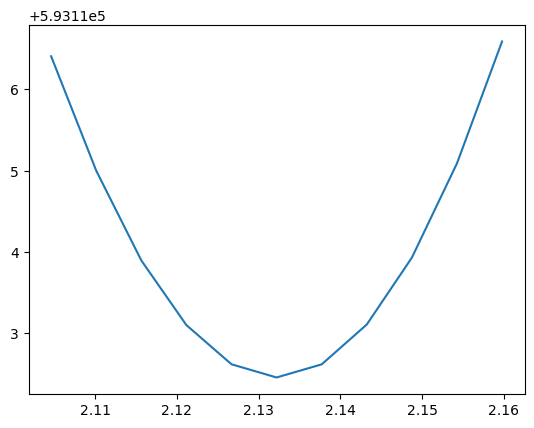

In [415]:
plt.plot(profile["GC.spectral.index_scan"], profile["stat_scan"])

### Eg:Using `select_nested_models` to compute significances

- Compute H0
- Compute H1
- perform a log likelihood lest

In [416]:
from gammapy.modeling.selection import select_nested_models

In [ ]:
# Test is there is a source 

In [431]:
dataset_pks = MapDataset.read("../datasets/pks2155.fits.gz")
dataset_pks

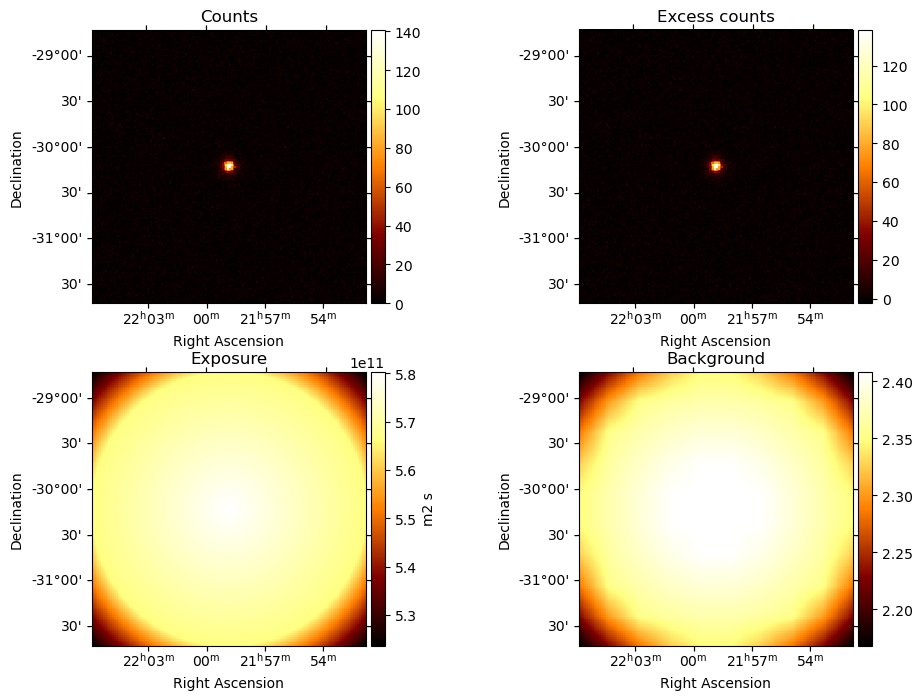

In [432]:
dataset_pks.peek()

In [463]:
pks_spectral = PowerLawSpectralModel()
pks_spatial = PointSpatialModel(lon_0=329.72*u.deg, lat_0=-30.225*u.deg)
model_pks = SkyModel(spatial_model=pks_spatial, spectral_model=pks_spectral)
pks_spatial.parameters.freeze_all()

In [464]:
select_nested_models?

Signature:
select_nested_models(
    datasets,
    parameters,
    null_values,
    n_sigma=2,
    n_free_parameters=None,
    fit=None,
)
Docstring:
Compute the test statistic (TS) between two nested hypothesis.

The null hypothesis is the minimal one, for which a set of parameters
are frozen to given values. The model is updated to the alternative hypothesis
if there is a significant improvement (larger than the given threshold).

Parameters
----------
datasets : `~gammapy.datasets.Datasets`
    Datasets.
parameters : `~gammapy.modeling.Parameters` or list of `~gammapy.modeling.Parameter`
    List of parameters frozen for the null hypothesis but free for the test hypothesis.
null_values : list of float or `~gammapy.modeling.Parameters`
    Values of the parameters frozen for the null hypothesis.
    If a `Parameters` object or a list of `Parameters` is given
    the null hypothesis follows the values of these parameters,
    so this tests linked parameters versus unliked.
n_sigma : f

In [465]:
dataset_pks.models = model_pks
results = select_nested_models(dataset_pks,
                              parameters=[model_pks.spectral_model.amplitude],
                               null_values=[0]
                              )
results

{'ts': 20600.016153759236,
 'fit_results': <gammapy.modeling.fit.FitResult at 0x755b60a2ccd0>,
 'fit_results_null': <gammapy.modeling.fit.FitResult at 0x755b61a03f10>}

In [481]:
# Or, search for a curvature in the spectrum

pks_spectral1 = ExpCutoffPowerLawSpectralModel()

model_pks1 = SkyModel(spatial_model=pks_spatial, spectral_model=pks_spectral1)

dataset_pks.models = [model_pks1]

result_cutoff = select_nested_models(dataset_pks,
                              parameters=[model_pks1.spectral_model.lambda_],
                              null_values=[0],
                              )

In [482]:
model_pks1.spectral_model.lambda_

Parameter(name='lambda_', value=0.03368979298666923, factor=0.33689792986669226, scale=0.1, unit=Unit("1 / TeV"), min=nan, max=nan, frozen=False, prior=None, id=0x755b62624490)

In [483]:
dataset_pks.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str8,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
ofCkS5Gq,,index,2.2894e+00,,1.381e-02,nan,nan,False,False,,
ofCkS5Gq,,amplitude,1.1169e-11,TeV-1 s-1 cm-2,1.948e-13,nan,nan,False,True,,
ofCkS5Gq,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
ofCkS5Gq,,lambda_,3.3690e-02,TeV-1,0.000e+00,nan,nan,False,False,,
ofCkS5Gq,,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,,
ofCkS5Gq,,lon_0,3.2972e+02,deg,0.000e+00,nan,nan,True,False,,
ofCkS5Gq,,lat_0,-3.0225e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,,


In [484]:
result_cutoff

{'ts': 10.608842115558218,
 'fit_results': <gammapy.modeling.fit.FitResult at 0x755b6c76a560>,
 'fit_results_null': <gammapy.modeling.fit.FitResult at 0x755b6e07c370>}

In [485]:
result_cutoff["fit_results_null"].models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str8,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
ofCkS5Gq,,index,2.3447e+00,,1.381e-02,nan,nan,False,False,,
ofCkS5Gq,,amplitude,1.0324e-11,TeV-1 s-1 cm-2,1.948e-13,nan,nan,False,True,,
ofCkS5Gq,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
ofCkS5Gq,,lambda_,0.0000e+00,TeV-1,0.000e+00,nan,nan,True,False,,
ofCkS5Gq,,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,,
ofCkS5Gq,,lon_0,3.2972e+02,deg,0.000e+00,nan,nan,True,False,,
ofCkS5Gq,,lat_0,-3.0225e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,,


### 3: FluxPointsEstimation

- bins with `nan`
- configuring `ul` limits
- likelohood profiles
- using likelihood profiles to combine points/ recompute ul
- Using EBL absorption

In [523]:
from gammapy.datasets import SpectrumDatasetOnOff

In [526]:
dataset = SpectrumDatasetOnOff.read(
    "../datasets/pks2155-304_steady.fits.gz"
)

index = 2.3
amplitude = 1.81 * 1e-12 * u.Unit("cm-2 s-1 TeV-1")
reference = 1 * u.TeV
pwl = PowerLawSpectralModel(index=index, amplitude=amplitude, reference=reference)
pwl.index.frozen = False
# Specify the redshift of the source
redshift = 0.116

# Load the EBL model. Here we use the model from Dominguez, 2011
absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)


# The power-law model is multiplied by the EBL to get the final model
spectral_model = pwl * absorption
print(spectral_model)

CompoundSpectralModel
    Component 1 : PowerLawSpectralModel

type    name     value         unit        error   min max frozen is_norm link prior
---- --------- ---------- -------------- --------- --- --- ------ ------- ---- -----
         index 2.3000e+00                0.000e+00 nan nan  False   False           
     amplitude 1.8100e-12 TeV-1 s-1 cm-2 0.000e+00 nan nan  False    True           
     reference 1.0000e+00            TeV 0.000e+00 nan nan   True   False           
    Component 2 : EBLAbsorptionNormSpectralModel

type    name      value    unit   error   min max frozen is_norm link prior
---- ---------- ---------- ---- --------- --- --- ------ ------- ---- -----
     alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False           
       redshift 1.1600e-01      0.000e+00 nan nan   True   False           
    Operator : mul



In [527]:
sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="pks2155")

dataset.models = sky_model

In [528]:
fit = Fit()
result = fit.run(datasets=[dataset])

# we make a copy here to compare it later
model_best = sky_model.copy()

print(result.models.to_parameters_table())

 model  type    name      value         unit        error   min max frozen is_norm link prior
------- ---- ---------- ---------- -------------- --------- --- --- ------ ------- ---- -----
pks2155           index 2.5531e+00                2.972e-01 nan nan  False   False           
pks2155       amplitude 1.2978e-11 TeV-1 s-1 cm-2 1.941e-12 nan nan  False    True           
pks2155       reference 1.0000e+00            TeV 0.000e+00 nan nan   True   False           
pks2155      alpha_norm 1.0000e+00                0.000e+00 nan nan   True   False           
pks2155        redshift 1.1600e-01                0.000e+00 nan nan   True   False           


In [543]:
energy_edges = dataset.counts.geom.axes["energy"].edges
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="pks2155", selection_optional="all"
)
flux_points_obs = fpe.run(datasets=[dataset])

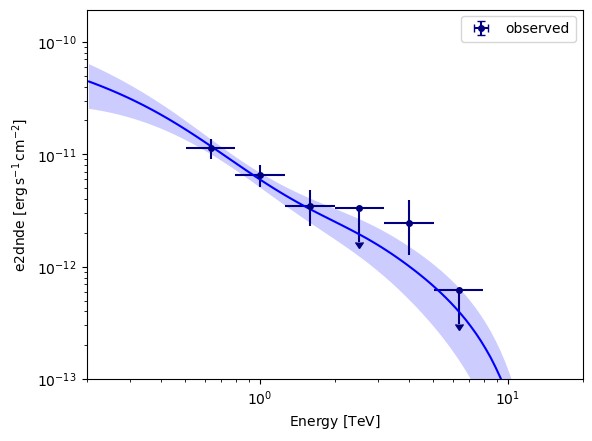

In [534]:
plt.figure()
sed_type = "e2dnde"
energy_bounds = [0.2, 20] * u.TeV
ax = flux_points_obs.plot(sed_type=sed_type, label="observed", color="navy")

model_best.spectral_model.plot(
    ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, color="blue"
)
model_best.spectral_model.plot_error(
    ax=ax, energy_bounds=energy_bounds, sed_type="e2dnde", facecolor="blue"
)
plt.ylim(bottom=1e-13)
plt.legend()
plt.show()

In [544]:
flux_points_obs.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.2517850823588335,0.2,0.31697863849222274,3.6476185547205857e-10,4.346426053858566e-11,1.0673521298551234e-11,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,False,0.0,False,nan .. nan,0.2 .. 4.999999999999999
0.399052462993776,0.31697863849222274,0.5023772863019161,8.815191100217283e-11,1.6824181186491365e-11,6.513089172719823e-12,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,False,0.0,False,nan .. nan,0.2 .. 4.999999999999999
0.6324555320336761,0.5023772863019161,0.7962143411069947,1.8511629700218934e-11,5.6784545161221335e-12,3.46939958260087e-12,0.9521544847501858,0.19137578025679308,0.18292099901751327,0.20050795836122326,1.3730120733987403,47.50171902023203,6.892149085751993,48.944252857477146,35.192947,6.49581729703641e-05,47.501783978405,False,49.0,True,24.77194444590009 .. 161.36351775069693,0.2 .. 4.999999999999999
1.0023744672545447,0.7962143411069947,1.2619146889603867,3.6975452157193015e-12,1.8054888358787298e-12,1.7495289932204186e-12,1.0956274031212367,0.24610456728287688,0.23347264190019545,0.2591546775848337,1.6408029353098605,38.66834976273503,6.218388035715931,37.99980164374364,27.749798,1.0586518328636885e-09,38.668349763793685,False,38.0,True,21.923762872302177 .. 99.94941696187902,0.2 .. 4.999999999999999
1.5886564694485632,1.2619146889603867,2.0000000000000004,8.068148966605462e-13,6.179559694154242e-13,9.533676161700257e-13,1.0601790011657177,0.3830394359478815,0.3554534975007576,0.4130692455154543,1.950089513352994,13.508405434022166,3.6753782708752802,17.975033935241605,11.890996,3.563818563634413e-05,13.508441072207802,False,18.0,True,7.766086629422034 .. 43.46302863066393,0.2 .. 4.999999999999999
2.517850823588335,2.0000000000000004,3.169786384922228,1.909232876848517e-13,2.296118496835082e-13,5.612110819798744e-13,0.45555124172746486,0.49063108318375365,nan,0.5553196822765698,1.7050624859935193,1.130649723024817,1.0633201413613949,5.997381873002158,2.3305814,1.2009969623250072e-06,1.1306509240217792,True,6.0,True,0.31367563280727495 .. 27.300375729598073,0.2 .. 4.999999999999999
3.9905246299377604,3.169786384922228,5.023772863019161,3.964803404491978e-14,7.670335277301098e-14,2.9489790485170584e-13,2.403554042236758,1.3093574948054474,1.1572593240757605,1.4737490274925822,nan,6.290860850923494,2.5081588567958555,6.9997948219089565,4.916456,6.163290322547255e-09,6.290860857086784,False,7.0,True,4.924276772263866 .. 2.6863550515317485,0.2 .. 4.999999999999999
6.324555320336762,5.023772863019161,7.96214341106995,6.270497049535078e-15,1.9757983625063597e-14,1.1871591189195438e-13,-1.7318481907369254,0.4803282554054728,0.8671405373529565,0.8671405373529546,1.5328067925439322,2.081105225910953,-1.4426036274427405,0.0,-1.0840327,5.412019568495907e-06,2.0811106379305215,True,0.0,True,2.3314865328448207 .. 8.340508010787879,0.2 .. 4.999999999999999


In [545]:
flux_points_obs.meta

{'n_sigma': 1,
 'n_sigma_ul': 2,
 'sed_type_init': 'likelihood',
 'SED_TYPE': 'likelihood'}

In [547]:
flux_points2 = flux_points_obs.recompute_ul(3)

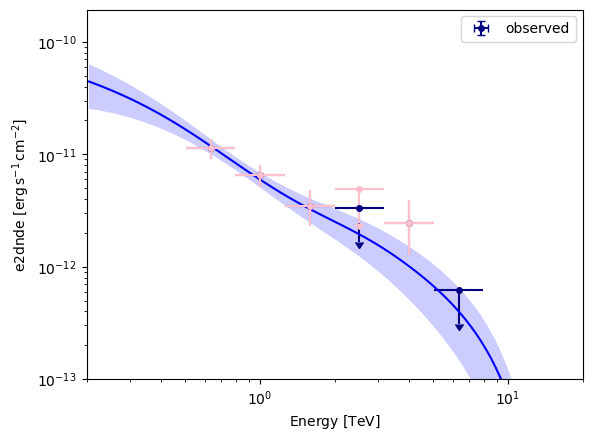

In [549]:
plt.figure()
sed_type = "e2dnde"
energy_bounds = [0.2, 20] * u.TeV
ax = flux_points_obs.plot(sed_type=sed_type, label="observed", color="navy")

model_best.spectral_model.plot(
    ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, color="blue"
)
model_best.spectral_model.plot_error(
    ax=ax, energy_bounds=energy_bounds, sed_type="e2dnde", facecolor="blue"
)

flux_points2.plot(ax=ax, sed_type=sed_type, color="pink")
plt.ylim(bottom=1e-13)
plt.legend()
plt.show()

In [550]:
flux_points2.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.2517850823588335,0.2,0.31697863849222274,3.6476185547205857e-10,4.346426053858566e-11,1.0673521298551234e-11,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,False,0.0,False,nan .. nan,0.2 .. 4.999999999999999
0.399052462993776,0.31697863849222274,0.5023772863019161,8.815191100217283e-11,1.6824181186491365e-11,6.513089172719823e-12,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,False,0.0,False,nan .. nan,0.2 .. 4.999999999999999
0.6324555320336761,0.5023772863019161,0.7962143411069947,1.8511629700218934e-11,5.6784545161221335e-12,3.46939958260087e-12,0.9521544847501858,0.19137578025679308,0.18292099901751327,0.20050795836122326,1.6116972706691983,47.50171902023203,6.892149085751993,48.944252857477146,35.192947,6.49581729703641e-05,47.501783978405,False,49.0,True,24.77194444590009 .. 161.36351775069693,0.2 .. 4.999999999999999
1.0023744672545447,0.7962143411069947,1.2619146889603867,3.6975452157193015e-12,1.8054888358787298e-12,1.7495289932204186e-12,1.0956274031212367,0.24610456728287688,0.23347264190019545,0.2591546775848337,1.9552670861961834,38.66834976273503,6.218388035715931,37.99980164374364,27.749798,1.0586518328636885e-09,38.668349763793685,False,38.0,True,21.923762872302177 .. 99.94941696187902,0.2 .. 4.999999999999999
1.5886564694485632,1.2619146889603867,2.0000000000000004,8.068148966605462e-13,6.179559694154242e-13,9.533676161700257e-13,1.0601790011657177,0.3830394359478815,0.3554534975007576,0.4130692455154543,2.488815256034708,13.508405434022166,3.6753782708752802,17.975033935241605,11.890996,3.563818563634413e-05,13.508441072207802,False,18.0,True,7.766086629422034 .. 43.46302863066393,0.2 .. 4.999999999999999
2.517850823588335,2.0000000000000004,3.169786384922228,1.909232876848517e-13,2.296118496835082e-13,5.612110819798744e-13,0.45555124172746486,0.49063108318375365,nan,0.5553196822765698,2.548045235453829,1.130649723024817,1.0633201413613949,5.997381873002158,2.3305814,1.2009969623250072e-06,1.1306509240217792,True,6.0,True,0.31367563280727495 .. 27.300375729598073,0.2 .. 4.999999999999999
3.9905246299377604,3.169786384922228,5.023772863019161,3.964803404491978e-14,7.670335277301098e-14,2.9489790485170584e-13,2.403554042236758,1.3093574948054474,1.1572593240757605,1.4737490274925822,nan,6.290860850923494,2.5081588567958555,6.9997948219089565,4.916456,6.163290322547255e-09,6.290860857086784,False,7.0,True,4.924276772263866 .. 2.6863550515317485,0.2 .. 4.999999999999999
6.324555320336762,5.023772863019161,7.96214341106995,6.270497049535078e-15,1.9757983625063597e-14,1.1871591189195438e-13,-1.7318481907369254,0.4803282554054728,0.8671405373529565,0.8671405373529546,nan,2.081105225910953,-1.4426036274427405,0.0,-1.0840327,5.412019568495907e-06,2.0811106379305215,True,0.0,True,2.3314865328448207 .. 8.340508010787879,0.2 .. 4.999999999999999


We have nans! What to do??

1. Increase the range of parameters being scanned

In [629]:
flux_points2.stat_scan

In [628]:
flux_points2.stat_scan.geom.axes["norm"].center

<Quantity [0.2       , 0.27594593, 0.38073079, 0.52530556, 0.72477966,
           1.        , 1.37972966, 1.90365394, 2.6265278 , 3.62389832,
           5.        ]>

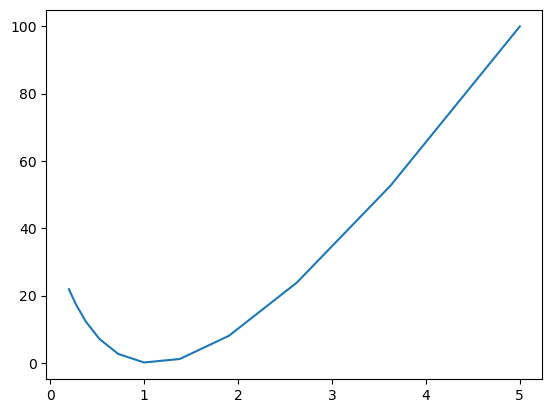

In [634]:
plt.plot(flux_points2.stat_scan.geom.axes["norm"].center,
        flux_points2.stat_scan.data[3].ravel())

In [619]:
fpe.norm.scan_min = 0.01
fpe.norm.scan_max = 100
fpe.n_sigma_ul = 3.0

In [650]:
flux_points3 = fpe.run(dataset)

In [621]:
flux_points3.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.2517850823588335,0.2,0.31697863849222274,3.6476185547205857e-10,4.346426053858566e-11,1.0673521298551234e-11,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,False,0.0,False,nan .. nan,0.010000000000000004 .. 100.00000000000004
0.399052462993776,0.31697863849222274,0.5023772863019161,8.815191100217283e-11,1.6824181186491365e-11,6.513089172719823e-12,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,False,0.0,False,nan .. nan,0.010000000000000004 .. 100.00000000000004
0.6324555320336761,0.5023772863019161,0.7962143411069947,1.8511629700218934e-11,5.6784545161221335e-12,3.46939958260087e-12,0.9521544847501858,0.19137578025679308,0.18292099901750394,0.20050795836122362,1.6107686525180576,47.50171902023203,6.892149085751993,48.944252857477146,35.192947,6.49581729703641e-05,47.501783978405,False,49.0,True,46.05949341597079 .. 6896.6785466429665,0.010000000000000004 .. 100.00000000000004
1.0023744672545447,0.7962143411069947,1.2619146889603867,3.6975452157193015e-12,1.8054888358787298e-12,1.7495289932204186e-12,1.0956274031212367,0.24610456728287688,0.233472641900195,0.2591546775849205,1.9547208975880968,38.66834976273503,6.218388035715931,37.99980164374364,27.749798,1.0586518328636885e-09,38.668349763793685,False,38.0,True,37.63268460138943 .. 4689.799712033611,0.010000000000000004 .. 100.00000000000004
1.5886564694485632,1.2619146889603867,2.0000000000000004,8.068148966605462e-13,6.179559694154242e-13,9.533676161700257e-13,1.0601790011657177,0.3830394359478815,0.35545349750068234,0.4130692455157894,2.4893978605178293,13.508405434022166,3.6753782708752802,17.975033935241605,11.890996,3.563818563634413e-05,13.508441072207802,False,18.0,True,13.159620726620119 .. 2069.9545069538635,0.010000000000000004 .. 100.00000000000004
2.517850823588335,2.0000000000000004,3.169786384922228,1.909232876848517e-13,2.296118496835082e-13,5.612110819798744e-13,0.45555124172746486,0.49063108318375365,0.43238558832273527,0.5553196822765606,2.5482267836779906,1.130649723024817,1.0633201413613949,5.997381873002158,2.3305814,1.2009969623250072e-06,1.1306509240217792,True,6.0,True,1.07428013484423 .. 964.8070453901612,0.010000000000000004 .. 100.00000000000004
3.9905246299377604,3.169786384922228,5.023772863019161,3.964803404491978e-14,7.670335277301098e-14,2.9489790485170584e-13,2.403554042236758,1.3093574948054474,1.1572593240757534,1.4737490274926048,7.8952496603093865,6.290860850923494,2.5081588567958555,6.9997948219089565,4.916456,6.163290322547255e-09,6.290860857086784,False,7.0,True,6.215809725979639 .. 351.721230557746,0.010000000000000004 .. 100.00000000000004
6.324555320336762,5.023772863019161,7.96214341106995,6.270497049535078e-15,1.9757983625063597e-14,1.1871591189195438e-13,-1.7318481907369254,0.4803282554054728,0.867140537352955,0.8671405373529469,5.526801503345897,2.081105225910953,-1.4426036274427405,0.0,-1.0840327,5.412019568495907e-06,2.0811106379305215,True,0.0,True,2.093629432676238 .. 127.26905809507764,0.010000000000000004 .. 100.00000000000004


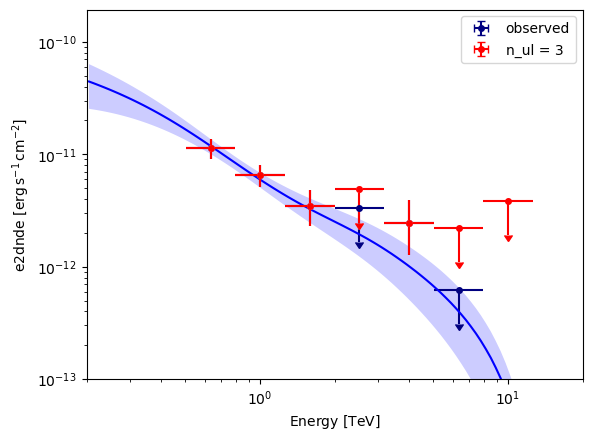

In [622]:
plt.figure()
sed_type = "e2dnde"
energy_bounds = [0.2, 20] * u.TeV
ax = flux_points_obs.plot(sed_type=sed_type, label="observed", color="navy")

model_best.spectral_model.plot(
    ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, color="blue"
)
model_best.spectral_model.plot_error(
    ax=ax, energy_bounds=energy_bounds, sed_type="e2dnde", facecolor="blue"
)

flux_points2.plot(ax=ax, sed_type=sed_type, color="pink")
flux_points3.plot(ax=ax, sed_type=sed_type, color="red", label="n_ul = 3")

plt.ylim(bottom=1e-13)
plt.legend()
plt.show()

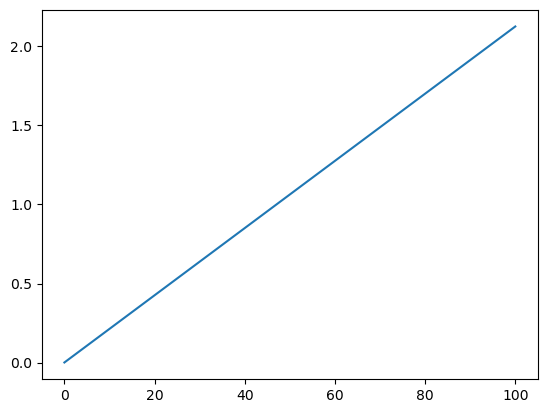

In [637]:
plt.plot(flux_points3.stat_scan.geom.axes["norm"].center,
        flux_points3.stat_scan.data[-1][:].ravel())

We can rebin the axis to avoid upper limits

In [641]:
from gammapy.estimators.utils import get_rebinned_axis
get_rebinned_axis?

Signature: get_rebinned_axis(fluxpoint, axis_name='energy', method=None, **kwargs)
Docstring:
Get the rebinned axis for resampling
 the flux point object along the mentioned axis.

Parameters
----------
fluxpoint : `gammapy.estimators.FluxPoints`
    The fluxpoint object to rebin
method : str
    The method to resample the axis. Supported options are
    fixed_bins and min-ts
kwargs : Dict
    keywords passed to get_edges_fixed_bins or
    get_edges_min_ts
    if method is fixed-bins, keyword should be group_size
    if method is min-ts, keyword should be ts_threshold
axis_name : The axis name to combine along

Returns
-------
axis_new : MapAxis or TimeMapAxis
    The new axis
File:      ~/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/estimators/utils.py
Type:      function

In [648]:
axis_new = get_rebinned_axis(flux_points3, method="min-ts", ts_threshold=4, axis_name="energy")
fp_rebinned = flux_points3.resample_axis(axis_new)

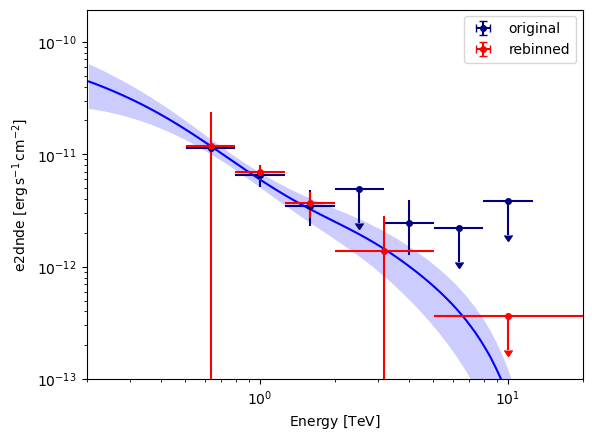

In [649]:
plt.figure()
sed_type = "e2dnde"
energy_bounds = [0.2, 20] * u.TeV
ax = flux_points3.plot(sed_type=sed_type, label="original", color="navy")

model_best.spectral_model.plot(
    ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, color="blue"
)
model_best.spectral_model.plot_error(
    ax=ax, energy_bounds=energy_bounds, sed_type="e2dnde", facecolor="blue"
)

fp_rebinned.plot(ax=ax, sed_type=sed_type, color="red", label="rebinned")

plt.ylim(bottom=1e-13)
plt.legend()
plt.show()

- All estimators follow a very similar API
- When estimators are executed, parameters of the source are kept **frozen**
- If `reoptimize=True`, other free parameters (eg: background, other source contributions, etc) are refit
- If `reoptimize=False` only the source normalisation is adjusted
- Estimators must be run *after* fitting

## Parallelisation

Gammpy has some `ray` support for parallel processing

- In `DatasetsMarker` and `Estimators`

In [651]:
from gammapy.makers import DatasetsMaker
DatasetsMaker?

Init signature:
DatasetsMaker(
    makers,
    stack_datasets=True,
    n_jobs=None,
    cutout_mode='trim',
    cutout_width=None,
    parallel_backend=None,
)
Docstring:     
Run makers in a chain.

Parameters
----------
makers : list of `Maker` objects
    Makers.
stack_datasets : bool, optional
    If True, stack into the reference dataset (see `run` method arguments).
    Default is True.
n_jobs : int, optional
    Number of processes to run in parallel.
    Default is one, unless `~gammapy.utils.parallel.N_JOBS_DEFAULT` was modified.
cutout_mode : {'trim', 'partial', 'strict'}
    Used only to cutout the reference `MapDataset` around each processed observation.
    Mode is an option for Cutout2D, for details see `~astropy.nddata.utils.Cutout2D`.
    Default is "trim".
cutout_width : tuple of `~astropy.coordinates.Angle`, optional
    Angular sizes of the region in (lon, lat) in that specific order.
    If only one value is passed, a square region is extracted.
    If None it retu

In [653]:
fpe

## Simulations

1. Full event sampling
   - Unbinned simulation at DL3 level
   - Useful for simulating a full Datastore (eg: the CTA SDC)
   - Also, for timing analysis
   - https://docs.gammapy.org/dev/tutorials/analysis-3d/event_sampling.html#sphx-glr-tutorials-analysis-3d-event-sampling-py
  
2. Binned simulations
   - Simulate directly at the DL4 level
   - Useful for sensitivity studies, quantifying systematics..
   - https://docs.gammapy.org/dev/tutorials/analysis-3d/simulate_3d.html#sphx-glr-tutorials-analysis-3d-simulate-3d-py